<b><font color='lightblue' size='5'>Importing Needed Libraries</font></b>




In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import shutil
from pathlib import Path
pd.set_option('display.max_colwidth', None)
import os
import tensorflow as tf
from google.colab import drive
import zipfile
import shutil
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
import math
import tensorflow as tf
from PIL import Image


<b><font color='lightblue' size='5'>Loading Data</font></b>




In [57]:
drive.mount('/content/drive')  #linking colab with my drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
os.chdir('/content/drive/MyDrive/ProjectANN')   # change directory to my data folder in drive


In [59]:
base_dir = '/content/drive/MyDrive/ProjectANN'  # the base directory the files are located in
train_df = pd.read_csv(base_dir + '/Train.csv')    # reading the train csv file contains (Imageid,Label)
test_df = pd.read_csv(base_dir + '/Test.csv')

In [60]:
train_dir='/content/drive/MyDrive/ProjectANN/train_U'    

In [6]:
#--- working with the data from the competetion ---#

In [7]:
# with zipfile.ZipFile('Images.zip', 'r') as zip_ref:  #unzipping the Images.zip file to imagess file 
#     zip_ref.extractall('imagess')

In [8]:
# # deleting all non RGB images (Red-Green-NearInfrared (RGNIR) images)
# directory = '/content/drive/MyDrive/ProjectANN/imagess'
# for filename in os.listdir(directory):
#     if filename.endswith('_rgn.jpg'):
#         print(f"Deleting file: {filename}")
#         os.remove(os.path.join(directory,filename ))

In [9]:
# # create train_UP for creating image folder contains images and its labels 
# train_dir = os.path.join(base_dir, 'train_Up')
# os.makedirs(train_dir, exist_ok=True)

In [10]:

# # Create subdirectories for each class label
# for label in train_df['Label'].unique():
#     label_dir = os.path.join(train_dir, label)
#     os.makedirs(label_dir, exist_ok=True)

# # Copy the image files into the appropriate subdirectories based on their labels
# for index, row in train_df.iterrows():
#     src = os.path.join(base_dir, 'imagess', row['Image_id'])
#     dst = os.path.join(train_dir, row['Label'], row['Image_id'])
#     if os.path.exists(src):

#       shutil.copy(src, dst)



In [11]:
# # Define data transforms
# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Create the ImageFolder dataset
# dataset = ImageFolder(train_dir, transform=transform)

# ##

<b><font color='lightblue' size='5'>Showing Data</font></b>


In [12]:
# for i in range(10):
#     image_path, label = dataset.samples[i]
#     image = Image.open(image_path)
#     image.show()

<b><font color='lightblue' size='5'>Using The Data</font></b>


In [61]:
BATCH_SIZE = 150
IMG_SIZE = (256, 256)

In [62]:
#create tensorflow dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
)


Found 2698 files belonging to 3 classes.


<b><font color='lightblue' size='5'>Splitting Training Data</font></b>


In [63]:
train_batches = math.ceil(len(train_dataset) * 0.9)
valid_batches = len(train_dataset) - train_batches

train_dataset = train_dataset.take(train_batches)
valid_dataset = train_dataset.take(valid_batches)


In [64]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(valid_dataset))

Number of training batches: 17
Number of validation batches: 1


In [65]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomRotation(0.5236), 
  tf.keras.layers.RandomFlip('vertical'),


])

<b><font color='lightblue' size='5'>Initializing The Pre-Trained Model</font></b>


In [66]:
IMG_SHAPE = (256, 256, 3)

base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False, # load the model without the classification layers at the top
                                            weights='imagenet')

In [67]:
base_model.trainable = False # freezing the the weights of all the layers in the model

In [20]:
base_model.summary(
)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

<b><font color='lightblue' size='5'>Adding Layers</font></b>


In [68]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(150, 8, 8, 2048)


In [69]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(150, 2048)


In [70]:
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')   
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(150, 3)


In [71]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input   

In [72]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.2)(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

<b><font color='lightblue' size='5'>Specifying the optimizer, loss function, and evaluation metrics</font></b>


In [73]:
base_learning_rate = 0.001

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=loss_fn,
             
              metrics=['sparse_categorical_crossentropy'])


            

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 8, 8, 2048)        0         
                                                             

<b><font color='lightblue' size='5'>Training The Model</font></b>


In [74]:
epochs = 30

In [75]:
class_weights = {0: 0.603, 1: 1.143, 2: 1.616}


In [76]:
# Define the early stopping callback
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=1)


In [77]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=valid_dataset,
                    class_weight=class_weights
                    ,callbacks=[early_stopping]
                    )


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


17/17 [==============================] - 26s 1s/step - loss: 1.1789 - sparse_categorical_crossentropy: 1.2059 - val_loss: 0.8874 - val_sparse_categorical_crossentropy: 0.8874
Epoch 2/30
17/17 [==============================] - 19s 918ms/step - loss: 0.8658 - sparse_categorical_crossentropy: 0.8947 - val_loss: 0.6170 - val_sparse_categorical_crossentropy: 0.6170
Epoch 3/30
17/17 [==============================] - 20s 1s/step - loss: 0.7891 - sparse_categorical_crossentropy: 0.8278 - val_loss: 0.5828 - val_sparse_categorical_crossentropy: 0.5828
Epoch 4/30
17/17 [==============================] - 18s 900ms/step - loss: 0.7248 - sparse_categorical_crossentropy: 0.7518 - val_loss: 0.5754 - val_sparse_categorical_crossentropy: 0.5754
Epoch 5/30
17/17 [==============================] - 18s 896ms/step - loss: 0.6685 - sparse_categorical_crossentropy: 0.6974 - val_loss: 0.4821 - val_sparse_categorical_crossentropy: 0.4821
Epoch 6/30
17/17 [==============================] - 18s 891ms/step - los

In [78]:
# Extract the true labels from the validation dataset
y_true = np.concatenate([y for x, y in valid_dataset], axis=0)

# Obtain the predicted labels from the model
y_pred_probabilities = model.predict(valid_dataset)
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

print("Confusion Matrix:")
print(cm)

1/1 [==============================] - 25s 25s/step
Confusion Matrix:
[[44 27 12]
 [16 17  6]
 [12 11  5]]


In [79]:
class_labels = ["Brown", "Blast", "Healthy"]

def print_confusion_matrix(cm, class_labels):
    n_classes = len(class_labels)
    print("Confusion Matrix:")
    print("Predicted")
    print("\t", end="")
    for label in class_labels:
        print(label, "\t", end="")
    print("\nActual")
    for i in range(n_classes):
        print(class_labels[i] + "\t", end="")
        for j in range(n_classes):
            prefix = ""
            if i == j:
                prefix = "TP: "  # True Positive
            elif cm[i, j] == 0:
                prefix = "TN: "  # True Negative
            elif cm[i, j] > 0:
                prefix = "FP: "  # False Positive
            else:
                prefix = "FN: "  # False Negative
            print(prefix + str(cm[i, j]) + "\t", end="")
        print()

# Assuming you have already calculated the confusion matrix
cm = np.array([[44, 27, 12],
 [16, 17,  6],
 [12, 11,  5]])

# Print the modified confusion matrix with TP, TN, FP, FN labels
print_confusion_matrix(cm, class_labels)


Confusion Matrix:
Predicted
	Brown 	Blast 	Healthy 	
Actual
Brown	TP: 44	FP: 27	FP: 12	
Blast	FP: 16	TP: 17	FP: 6	
Healthy	FP: 12	FP: 11	TP: 5	


In [80]:
def print_confusion_matrix(cm):
    print("Confusion Matrix:")
    print(cm)
    
    print("\nTrue Positives (TP): ", cm[0, 0])
    print("True Negatives (TN): ", cm[1, 1])
    print("True Negatives (TN): ", cm[2, 2])
    
    print("\nFalse Positives (FP): ", cm[0, 1])
    print("False Negatives (FN): ", cm[1, 0])
    print("False Negatives (FN): ", cm[2, 0])


In [81]:
# Assuming you have already calculated the confusion matrix
cm = np.array([[44, 27, 12],
 [16, 17,  6],
 [12, 11,  5]])

# Print the confusion matrix with TP, TN, FP, FN labels
print_confusion_matrix(cm)


Confusion Matrix:
[[44 27 12]
 [16 17  6]
 [12 11  5]]

True Positives (TP):  44
True Negatives (TN):  17
True Negatives (TN):  5

False Positives (FP):  27
False Negatives (FN):  16
False Negatives (FN):  12


In [ ]:

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

<Axes: >

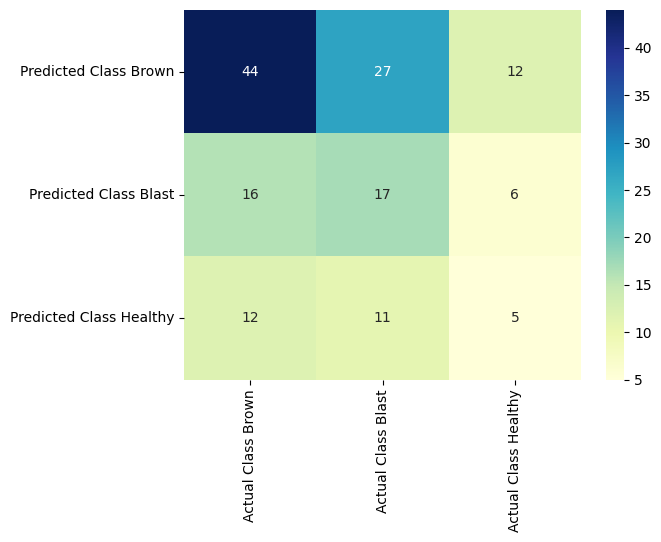

In [82]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Class Brown', 'Actual Class Blast', 'Actual Class Healthy'],
                         index=['Predicted Class Brown', 'Predicted Class Blast', 'Predicted Class Healthy'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')


In [32]:
#model.save_weights('my_modelT_weights.h5')   #

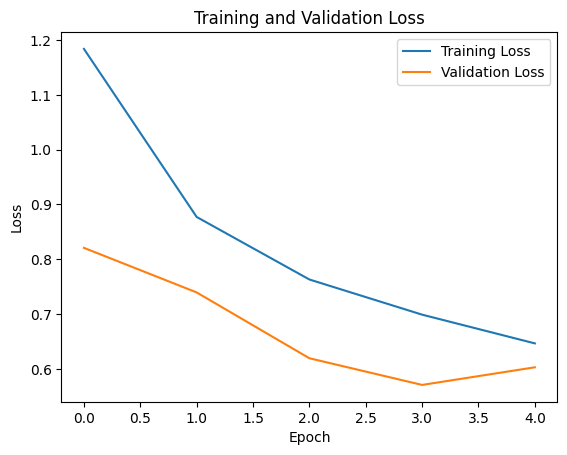

In [42]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

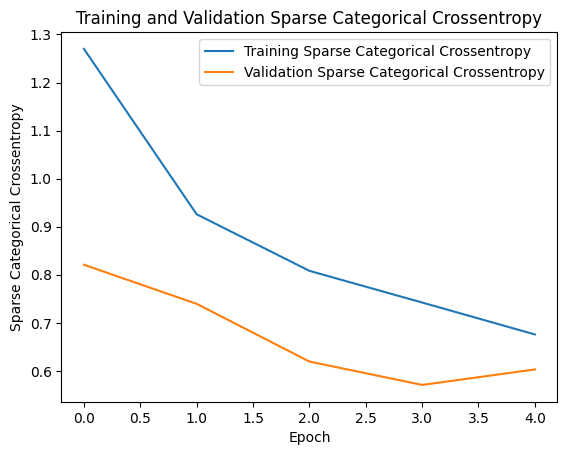

In [43]:
# Plot the training and validation sparse categorical crossentropy
plt.plot(history.history['sparse_categorical_crossentropy'], label='Training Sparse Categorical Crossentropy')
plt.plot(history.history['val_sparse_categorical_crossentropy'], label='Validation Sparse Categorical Crossentropy')
plt.title('Training and Validation Sparse Categorical Crossentropy')
plt.xlabel('Epoch')
plt.ylabel('Sparse Categorical Crossentropy')
plt.legend()
plt.show()

<b><font color='lightblue' size='5'>Fine Tuning</font></b>


In [83]:
base_model.trainable = True

In [84]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [85]:
# Fine-tune from this layer onwards
fine_tune_at = 160
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
base_learning_rate= 0.0001

In [86]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['sparse_categorical_crossentropy'])

In [ ]:
model.summary()

In [87]:
fine_tune_epochs =  epochs + 30

history_fine = model.fit(train_dataset,
                         epochs=fine_tune_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_dataset,class_weight=class_weights,
                         callbacks=[early_stopping])

Epoch 6/60


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


17/17 [==============================] - 28s 1s/step - loss: 1.6602 - sparse_categorical_crossentropy: 1.6391 - val_loss: 0.7448 - val_sparse_categorical_crossentropy: 0.7448
Epoch 7/60
17/17 [==============================] - 21s 1s/step - loss: 0.7993 - sparse_categorical_crossentropy: 0.8418 - val_loss: 0.6278 - val_sparse_categorical_crossentropy: 0.6278
Epoch 8/60
17/17 [==============================] - 21s 995ms/step - loss: 0.7235 - sparse_categorical_crossentropy: 0.7763 - val_loss: 0.6554 - val_sparse_categorical_crossentropy: 0.6554


In [49]:
from sklearn.metrics import confusion_matrix



In [ ]:
#model.save_weights('my_modelF_weights.h5')    #

In [88]:
# Extract the true labels from the validation dataset
y_true = np.concatenate([y for x, y in valid_dataset], axis=0)

# Obtain the predicted labels from the model
y_pred_probabilities = model.predict(valid_dataset)
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

print("Confusion Matrix:")
print(cm)

1/1 [==============================] - 13s 13s/step
Confusion Matrix:
[[57 24 15]
 [16 10  8]
 [12  7  1]]


In [89]:
def print_confusion_matrix(cm):
    print("Confusion Matrix:")
    print(cm)
    
    print("\nTrue Positives (TP): ", cm[0, 0])
    print("True Negatives (TN): ", cm[1, 1])
    print("True Negatives (TN): ", cm[2, 2])
    
    print("\nFalse Positives (FP): ", cm[0, 1])
    print("False Negatives (FN): ", cm[1, 0])
    print("False Negatives (FN): ", cm[2, 0])


In [90]:
# Assuming you have already calculated the confusion matrix
cm = np.array([[57, 24, 15],
 [16, 10,  8],
 [12,  7,  1]])

# Print the confusion matrix with TP, TN, FP, FN labels
print_confusion_matrix(cm)


Confusion Matrix:
[[57 24 15]
 [16 10  8]
 [12  7  1]]

True Positives (TP):  57
True Negatives (TN):  10
True Negatives (TN):  1

False Positives (FP):  24
False Negatives (FN):  16
False Negatives (FN):  12


<Axes: >

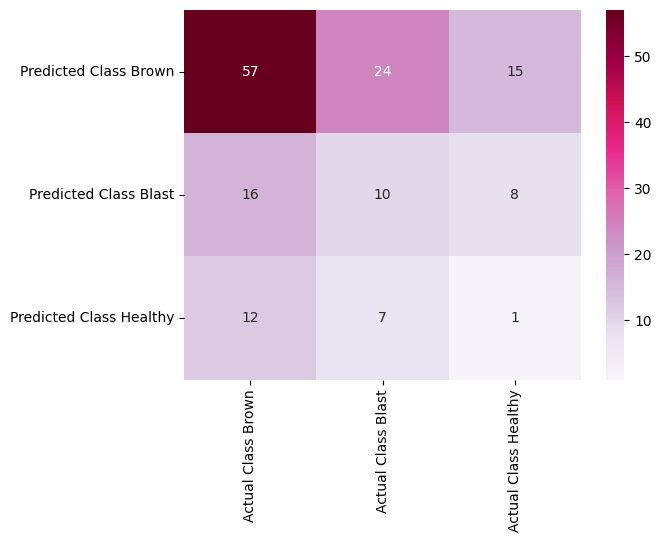

In [91]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Class Brown', 'Actual Class Blast', 'Actual Class Healthy'],
                         index=['Predicted Class Brown', 'Predicted Class Blast', 'Predicted Class Healthy'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='PuRd')


In [52]:
class_labels = ["Brown", "Blast", "Healthy"]

def print_confusion_matrix(cm, class_labels):
    n_classes = len(class_labels)
    print("Confusion Matrix:")
    print("Predicted")
    print("\t", end="")
    for label in class_labels:
        print(label, "\t", end="")
    print("\nActual")
    for i in range(n_classes):
        print(class_labels[i] + "\t", end="")
        for j in range(n_classes):
            prefix = ""
            if i == j:
                prefix = "TP: "  # True Positive
            elif cm[i, j] == 0:
                prefix = "TN: "  # True Negative
            elif cm[i, j] > 0:
                prefix = "FP: "  # False Positive
            else:
                prefix = "FN: "  # False Negative
            print(prefix + str(cm[i, j]) + "\t", end="")
        print()

# Assuming you have already calculated the confusion matrix
cm = np.array([[21, 31, 29], [19, 15, 12], [12,  5,  6]])

# Print the modified confusion matrix with TP, TN, FP, FN labels
print_confusion_matrix(cm, class_labels)


Confusion Matrix:
Predicted
	Brown 	Blast 	Healthy 	
Actual
Brown	TP: 21	FP: 31	FP: 29	
Blast	FP: 19	TP: 15	FP: 12	
Healthy	FP: 12	FP: 5	TP: 6	


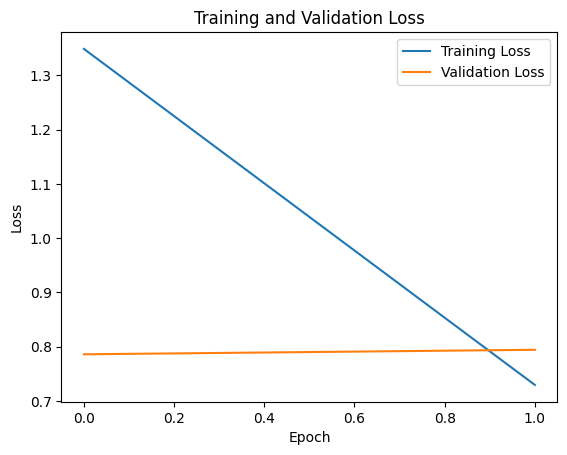

In [54]:
# Plot the training and validation loss
plt.plot(history_fine.history['loss'], label='Training Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

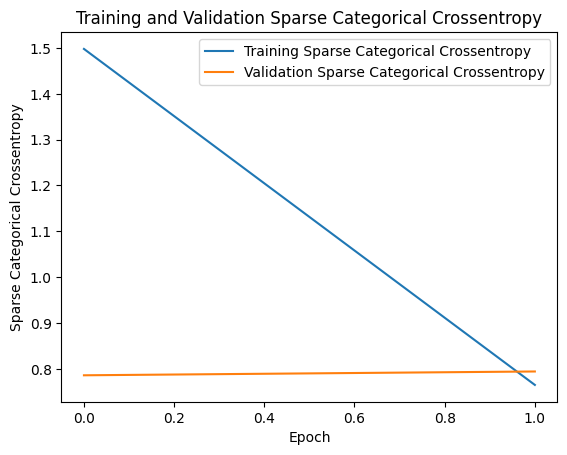

In [55]:
# Plot the training and validation sparse categorical crossentropy
plt.plot(history_fine.history['sparse_categorical_crossentropy'], label='Training Sparse Categorical Crossentropy')
plt.plot(history_fine.history['val_sparse_categorical_crossentropy'], label='Validation Sparse Categorical Crossentropy')
plt.title('Training and Validation Sparse Categorical Crossentropy')
plt.xlabel('Epoch')
plt.ylabel('Sparse Categorical Crossentropy')
plt.legend()
plt.show()

In [ ]:
model.summary()


In [ ]:
### 

In [92]:
import os
import numpy as np
from PIL import Image

test_folder = '/content/drive/MyDrive/ProjectANN/test'
image_size = (256, 256)

images = []

for filename in os.listdir(test_folder):
    if filename.endswith('.jpg'):
        image_path = os.path.join(test_folder, filename)
        image = Image.open(image_path)

        resized_image = image.resize(image_size)

        image_array = np.array(resized_image)

        images.append(image_array)

test_data = np.array(images)



In [93]:
test_df = pd.read_csv(base_dir + '/Test.csv')

In [94]:
import csv

predictions = model.predict(test_data)


In [95]:

submission_df = pd.read_csv('/content/drive/MyDrive/ProjectANN/SampleSubmission (5).csv', header=0)

prediction_df = pd.DataFrame({'Image_id': submission_df['Image_id']})


prediction_df['brown'] = predictions[1:, 0]
prediction_df['blast'] = predictions[1:, 1]
prediction_df['healthy'] = predictions[1:, 2]

prediction_df.to_csv('SampleSubmission.csv', index=False)